# [Lightkurve](https://docs.lightkurve.org/)

## Table of Contents
- [Overview](#overview)
- [A Quick Introduction](#a-hands-on-introduction)

# Overview
Lightkurve is a user-friendly Python package that is designed to make interacting with TESS and Kepler time-series photometry easy and accessible. It is well documented, and there are pre-existing [tutorials](https://docs.lightkurve.org/tutorials/index.html) that covers most functionality. This lesson will go over the primary use-cases, best practices, and examples, as well as some exercises to practice and improve understanding. 

# A Hands-On Introduction
There are three primary objects used in `Lighkurve`:
* `LightCurve` object
* `TargetPixelFile` objects
* `Periodogram` objects

Before diving into the details of these objects, this first section will give a quickstart by getting you downloading, plotting, and visualizing an exoplanet transit. 

First, we import `lightkurve`:

In [30]:
import lightkurve as lk
from matplotlib import pyplot as plt
import numpy as np

The first step is to download the `target pixel file`, which are the 2D images used to construct the timeseries photometry. Let's investigate the known exoplanet system **WASP-121**:

In [5]:
## Downloads all pixel files for the target
pixelfile = lk.search_targetpixelfile("WASP-121").download_all()

Let's check out the first image.

<class 'lightkurve.targetpixelfile.TessTargetPixelFile'>


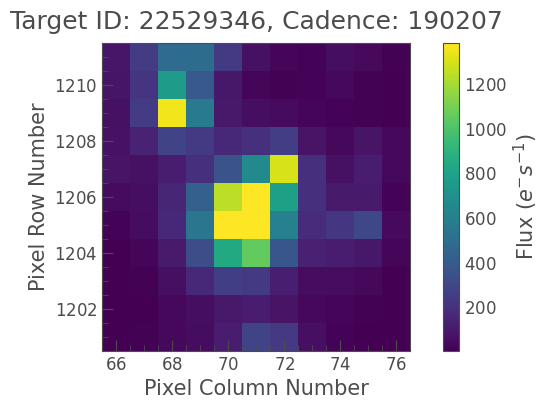

In [6]:
##Check out different images by changing the index!
pixelfile[0].plot()

##We can check the type to see which mission it's derived from (TESS or Kepler)
print(type(pixelfile[0]))

To see the light curve from this data, we use `pixelfile.to_lightcurve`:

In [7]:
##Select a target pixel to analyze, which contains one sector of timeseries data
lc = pixelfile[3].to_lightcurve(aperture_mask='all')

##Plot the results!
lc.plot()

<Axes: xlabel='Time - 2457000 [BTJD days]', ylabel='Flux [$\\mathrm{e^{-}\\,s^{-1}}$]'>

We can see repeated, deep transit signal here, but what if we want a better view? We can easily access different parts of the light curve by normal Python splicing:

<Axes: xlabel='Time - 2457000 [BTJD days]', ylabel='Flux [$\\mathrm{e^{-}\\,s^{-1}}$]'>

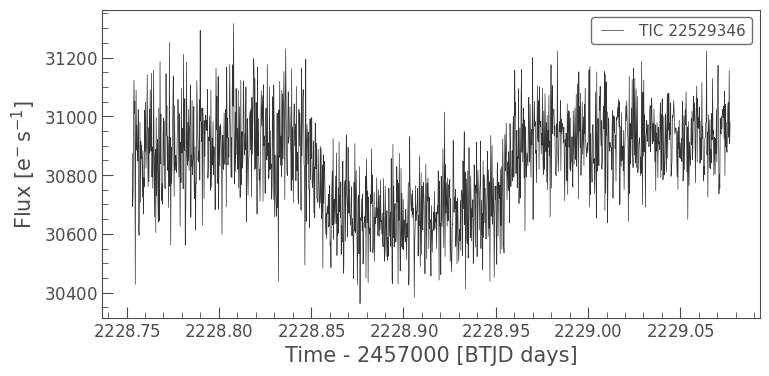

In [50]:
lc[0:1400].plot()

Congrats, you found `WASP-121 b` in real TESS data! The next sections will go more in-depth into the different functions of the three objects in the `lightcurve` module, and will finish with standard work flows that accomplish specific tasks i.e. light-curve detrending.

# [`Lightkurve` Objects](https://docs.lightkurve.org/reference/index.html)
The following will briefly highlight the primary properties and functions of the three `Lightcurve` objects.

## [The LightCurve Object](https://docs.lightkurve.org/reference/lightcurve.html)
This is the object we constructed above. The `Lightcurve` object requires, at a minimum, three parameters:
- Time (`time`)
- Flux (`flux`)
- Flux Error (`flux_err`)

### Construction
`LightCurves` can be constructed like above using `targetpixelfile` objects, or by passing three array-like objects to the `time`, `flux` and `flux_err` parameters. We can retrieve these arrays by passing `LightCurve.time/flux/flux_err`. Using the example above:

In [8]:
#Retrieve the data columns
print(lc.time, lc.flux, lc.flux_err)

#Retrieve metadata
print(lc.meta)

[2228.75309684 2228.75332832 2228.7535598  ... 2254.06842987 2254.06866134
 2254.06889282] [30873.088 30692.766 30750.527 ... 30551.371 30616.508 30738.994] electron / s [86.92682  86.82539  86.83288  ... 50.719883 51.18822  50.73446 ] electron / s
{'APERTURE_MASK': 'all', 'TARGETID': 22529346, 'LABEL': 'TIC 22529346', 'SECTOR': 34, 'CAMERA': 3, 'CCD': 2, 'MISSION': 'TESS', 'RA': 107.600252516386, 'DEC': -39.0973807094915}


### Visualization
`Lightkurve` offers four different routines for plotting. Since these routines are made using `matplotlib`, we can manipulate any plot with `matplotlib` methods. We can examine them below:

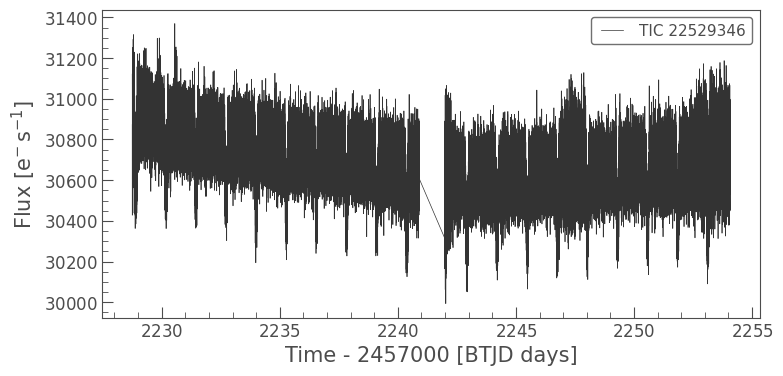

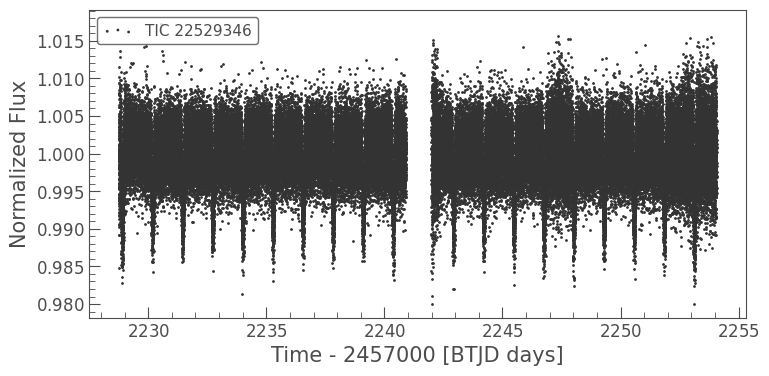

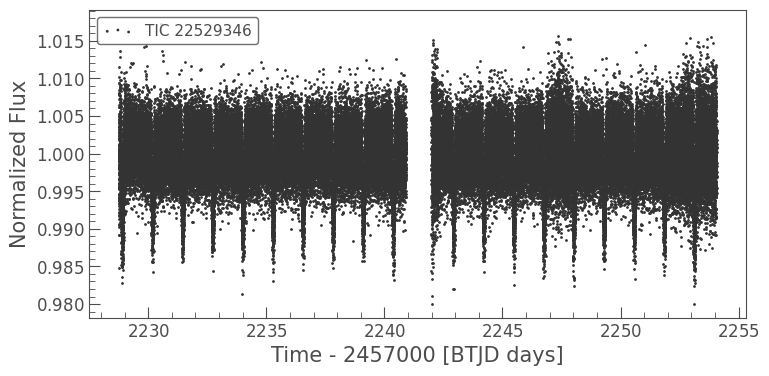

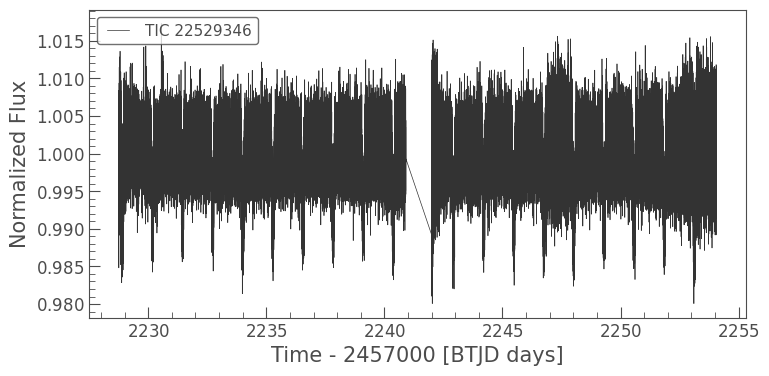

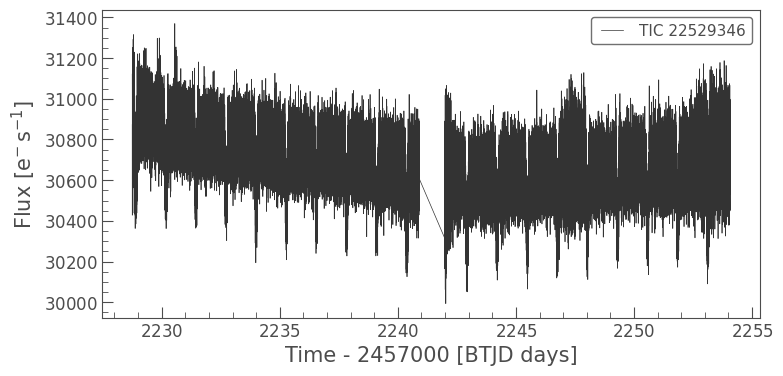

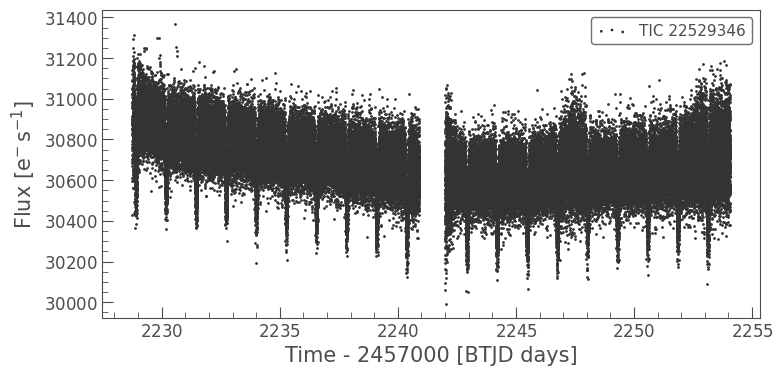

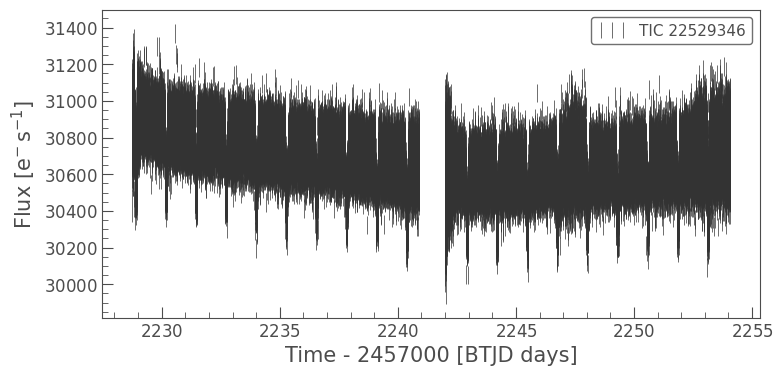

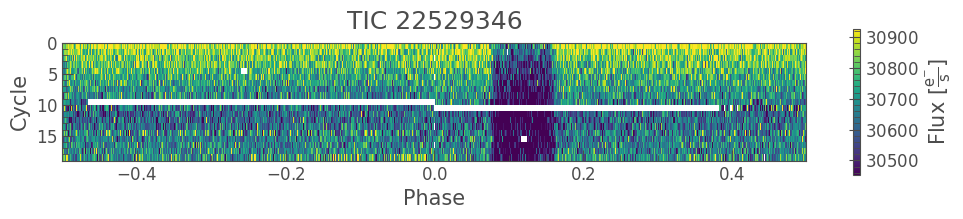

In [12]:
#Standard plot with linear interpolation
lc.plot()
plt.show()
input('Press any key to continue to the scatter plot')
lc.scatter()
plt.show()
input('Press any key to continue to the errobar plot')
lc.errorbar()
plt.show()
input('Press any key to continue to the river plot')

## River plots phase folds the light curve on a set period. For exoplanets, it essentially takes
## each transit and plots it on top of each other, which helps the SNR of the signal,
## Here, the transit manifest itself as a continuous dark band across the data at ~0.1 phase
lc.plot_river(period=1.2749255)
plt.show()

### Data Mainpulation
In order to conduct research, we can apply a variety of useful methods on the light curve in order to clean and reconstruct the lightcurves into something more useful.

#### Detrending/Flattening
The lightcurves above are not perfectly flat, which can be due to systematic effects, variability of the hosts, or stellar rotation modulation due to star spots. To mitiage this, we can use `LightCurve.flatten`, which applies a [Savitzky-Golay filter](https://en.wikipedia.org/wiki/Savitzky%E2%80%93Golay_filter) to remove these trends without effecting the short-term variation.

<div class="alert alert-block alert-info">
 
**IMPORTANT**: When detrending/flattening, the `window_lenth` parameter should be adjusted based on the time-scale of the underlying baseline variation. For example, the light-curves above seem to vary over the entire course of the observations. Thus, the window length should be well within the thousands of data points (~days).

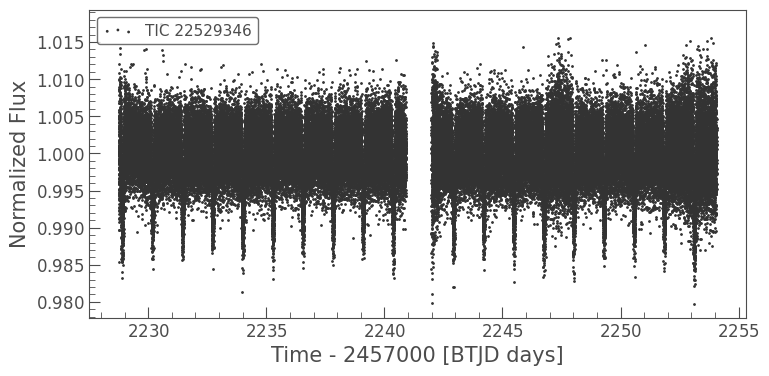

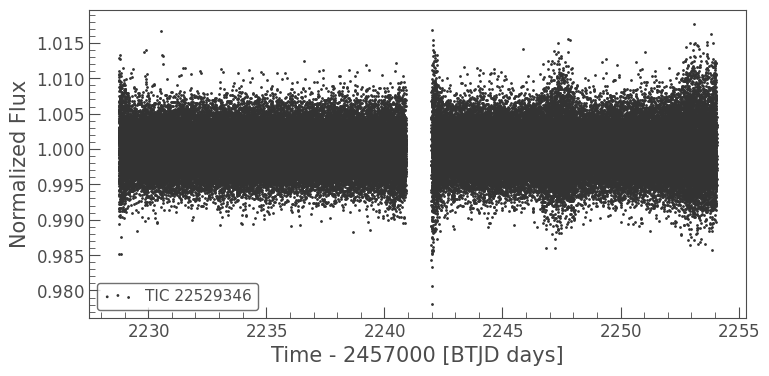

In [38]:
##We need to change the default window_length here, which is 101 data points. This is too short a 
##timescale for our data, which varies over thousands of data points. Otherwise, we will detrend the
## the transits.
lc2 = lc.flatten(window_length=10001)
lc2.scatter()
plt.show()


##An example of bad flattening, even by using the defaults. We've lost our transits!
##Be wary of this. Check the original data to ensure you do not lose important signal
lc3 = lc.flatten()
lc3.scatter()
plt.show()


This flattened fairly well, while maintaining the depths of the transits. If there are shorter-frequency signals, you can also use the `mask` parameter in the flatten routine to make the routine ignore certain data points. The mask must be an Boolean array, where `True` data will not be considered in the detrending. This can be used to safely preserve the transits.

#### Clean-up Routines
We can use the `LightCurve.remove_nans` and `LightCurve.remove_outliers` routines to get rid of invalid or spurious data points. 

NOTE: `LightCurve.flatten` will automatically remove outliers, which can be adjusted using the `sigma` parameter. Additionally, it automatically normalizes the light curve, which has its own routine `LightCurve.noramlize()`.

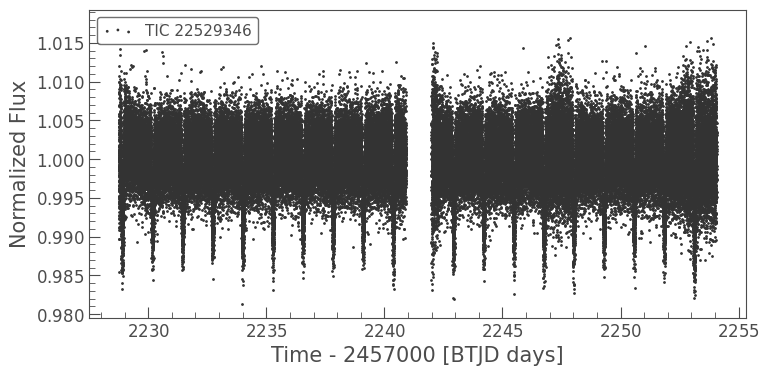

In [40]:
#Remove nans in-place, no need to redefine the variable
lc2 = lc2.remove_nans()
#Clip any spurious data points
lc2 = lc2.remove_outliers(sigma = 5)
lc2.scatter()
plt.show()

#### Phase-Folding and Binning
To get a better constraint on the shape of the transit, we can phase-fold and bin (essentially multi-point averages).